In [ ]:
clients = ['tsung']
tools = ['pcap', 'sql_dump']
clients_and_tools = clients + tools

EV_MAP = dict(
    tls_reneg = 'TLS',
    redos = 'Redos',
    laughs = 'Laughs',
    slowloris = 'Slowloris',
    rudy = 'RUDY',
    flood = 'Flash Crowd'
)

def plot_attacks(traffic, ax, x, lims, dotext, events_map):
    for index, event in enumerate(traffic.name.unique()):
        if event in clients_and_tools:
            continue

        event_occur = traffic[traffic.name == event]
        
        for i in range(0, event_occur.shape[0], 2):
            start_row = event_occur.iloc[i]
            end_row = event_occur.iloc[i+1]
        
            start = int(start_row.time)
            end = int(end_row.time)
        
            ax.axvline(start, color='r', alpha=.25)                                                                                                                                                              
            ax.axvline(end, color='r', alpha=.25)
            ax.fill_between(x, lims[0]/10.0, lims[1]*10.0, where= (start < np.array(x)) & (np.array(x) < end),
                            facecolor='red', alpha=.1)
            if dotext:
                ax.text((start + end)/2, lims[1] * 2, events_map[event], color='maroon', fontweight='bold', ha='center')
        ax.set_ylim([lims[0], lims[1]])

def tag_attacks(traffic, events_map):
    for index, event in enumerate(traffic.name.unique()):
        if event in clients_and_tools:
            continue

        event_occur = traffic[traffic.name == event]
        
        for i in range(0, event_occur.shape[0], 2):
            start_row = event_occur.iloc[i]
            end_row = event_occur.iloc[i+1]
        
            start = int(start_row.time)
            end = int(end_row.time)

            plt.text((start + end)/2, 0.5, events_map[event], color='maroon', fontweight='bold', ha='center')#, rotation=90)

            
def plot_df(df, cols, fsize=(15,30)):
    fig, axs = plt.subplots(nrows=len(cols), ncols=1, sharex=True, figsize=fsize)
    tag_attacks(traffic, EV_MAP)
    for i, column in enumerate(cols):
        axs[i].set_title(column, y=0.5, loc='right')
        if df.columns.contains('predictions'):
            df_correct = df[df.predictions == True]
            df_incorrect = df[df.predictions == False]
            axs[i].plot(df_correct.ts, df_correct[column], 'b.')
            axs[i].plot(df_incorrect.ts, df_incorrect[column], 'r.')
        else:
            axs[i].plot(df.ts, df[column], '.')
        plot_attacks(traffic, axs[i], df.ts.values, axs[i].get_ylim(), False, EV_MAP)

In [ ]:
'''
If test_exps is not given, will take whatever is not in train
'''
def split_train_test(df, train_exps, test_exps=None):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for train_exp in train_exps:
        train_df = train_df.append(df[(df.ts >= train_exp['start_time']) & (df.ts <= train_exp['end_time'])])
        
    if test_exps is None:
        test_df = df.iloc[df.index.difference(train_df.index)]
        #Remove samples with no labels
        notrafficlocs = test_df.traffic[test_df.traffic == ''].index
        test_df.drop(df.index[notrafficlocs], inplace=True)
    else:
        for test_exp in test_exps:
            test_df = test_df.append(df[(df.ts >= test_exp['start_time']) & (df.ts <= test_exp['end_time'])])

    return train_df, test_df

'''
Helper to index experiments
Assume all experiments are of the like: "tsung start, event start, event ends, tsung ends"
returns {'tls_reneg': [{'start_time': 123, 'end_time' : 456}], 'redos' : ...}
'''
def sort_experiments(traffic):
    tsung_traffic = traffic[traffic.name == 'tsung']
    exp_indexes = tsung_traffic.index.tolist()
    exp_tuples = list(zip(exp_indexes, exp_indexes[1:]))[::2]

    experiments = {}
    for ev in exp_tuples:
        ev_start = ev[0]
        ev_end = ev[1]
        exp_label = traffic.iloc[ev_start+1]['name']
        if exp_label in experiments:
            experiments[exp_label].append({'start_time' : traffic.iloc[ev_start].time, 'end_time' : traffic.iloc[ev_end].time})
        else:
            experiments[exp_label] = [{'start_time' : traffic.iloc[ev_start].time, 'end_time' : traffic.iloc[ev_end].time}]

    return experiments

'''
Squash datapoints between two experiments
'''
def squeeze_smore(df, traffic):
    # get only client traffic
    tsung_traffic = traffic[traffic.name == 'tsung'].reset_index()
    # drop first and last rows:
    tsung_traffic.drop(tsung_traffic.index[[0,tsung_traffic.shape[0] - 1]], inplace=True)

    times = list(map(round, tsung_traffic.time.tolist()))
    times_tuples = list(zip(times, times[1:]))[::2]

    smore_df = df.copy(deep=True)
    # Drop traffic in between experiments
    for t in times_tuples:
        indexes = df[(df.ts > t[0]) & (df.ts < t[1])].index

        smore_df.drop(smore_df.index[indexes], inplace=True)

    return smore_df.reset_index(drop=True)

In [ ]:
def build_dataframe(percentiles, start, end, stats=None, msu_type=None, flatten_by=['name', 'percentile', 'msu_type_id']):
    if not isinstance(percentiles, list):
        percentiles = [percentiles]
    
    df = pd.DataFrame()

    #Get components' stats
    if msu_type is None:
        msu_ids = db.get_msus().msu_id.unique()
    else:
        msu_ids = db.get_msus(msu_type_id=msu_type).msu_id.unique()
        
    df_msu = db.get_multi_stat_timeseries(percentile=percentiles, start=start, end=end, round_to=1.0, stat_name=stats, msu_id=msu_ids)
    if not (df_msu is None or df_msu.empty):
        df_msu = db.flatten_timeseries(df_msu, flatten_by)
        df = df_msu

    #Get runtimes' stats
    rt_ids = db.get_runtimes().id.values
    rt_ids = [1,2,3]
    df_rt = db.get_multi_stat_timeseries(percentile=percentiles, start=start, end=end, round_to=1.0, stat_name=stats, runtime_id=rt_ids)
    if df_rt is None or df_rt.empty:
        return df

    df_rt.loc[:, ['name']] = df_rt.loc[:, ['name']] + '_rt'
    df_rt = db.flatten_timeseries(df_rt, ['name', 'percentile'])
    df = df.merge(df_rt, on='ts')

    return df

def get_built_df(entry, flatten_type, percentiles, clear_cache=False, stats=None, msu_type=None):
    if clear_cache is True:
        del(cache[entry])

    start = min(events[events.status == 'start'].time)
    end = max(events[events.status == 'end'].time)

    if entry not in cache:
        df = build_dataframe(percentiles, start, end, flatten_by=flatten_type, stats=stats, msu_type=msu_type)
        df = db.label_timeseries(df, traffic)
        cache[entry] = df
    else:
        df = cache[entry]
    
    no = ['level_0', 'ts', 'index', 'STAT', 'LIFETIME', 'traffic'] # Convenient
    cols = []
    for col in df.columns:
        if (next((s for s in no if s in col), None)) or ('_size_' in col):
            continue
    #     # MinMax (0-1) scaling
    #     df[col] = df[col].sub(df[col].min()).div((df[col].max() - df[col].min()))
        cols.append(col)

    #Remove "holes" in between concatenated experiments
    return squeeze_smore(df, traffic), cols

In [ ]:
#Globals and config
# Update this cell with your setup 
repo = '/your/path/to/CPE_analytic'
cfg = dict(
    db_name='dbname',
    db_user='dbuser',
    db_port='dbport',
    db_ip='dbip',
    db_pwd='dbpwd'
)

In [ ]:
# Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(repo)

In [ ]:
from dedos_analytic.database.db_api import DbApi
db = DbApi(**cfg)

In [27]:
events = db.get_events()
traffic = events[~events.name.isin(tools)]
print(traffic.to_string())

      pk          time       name status  start_rate  end_rate  rate  duration                            url  sockets
0      1     10.340000      tsung  start           0         0  2000       600                              0        0
1      2    610.340000      tsung    end           0         0  2000       600                              0        0
2      3    160.340000      flood  start           0         0   300       300                              0        0
3      4    460.340000      flood    end           0         0   300       300                              0        0
5      6    620.356731      tsung  start           0         0  2000       600                              0        0
6      7   1220.356731      tsung    end           0         0  2000       600                              0        0
7      8    770.356731      flood  start           0         0   450       300                              0        0
8      9   1070.356731      flood    end        

In [ ]:
cache = {}

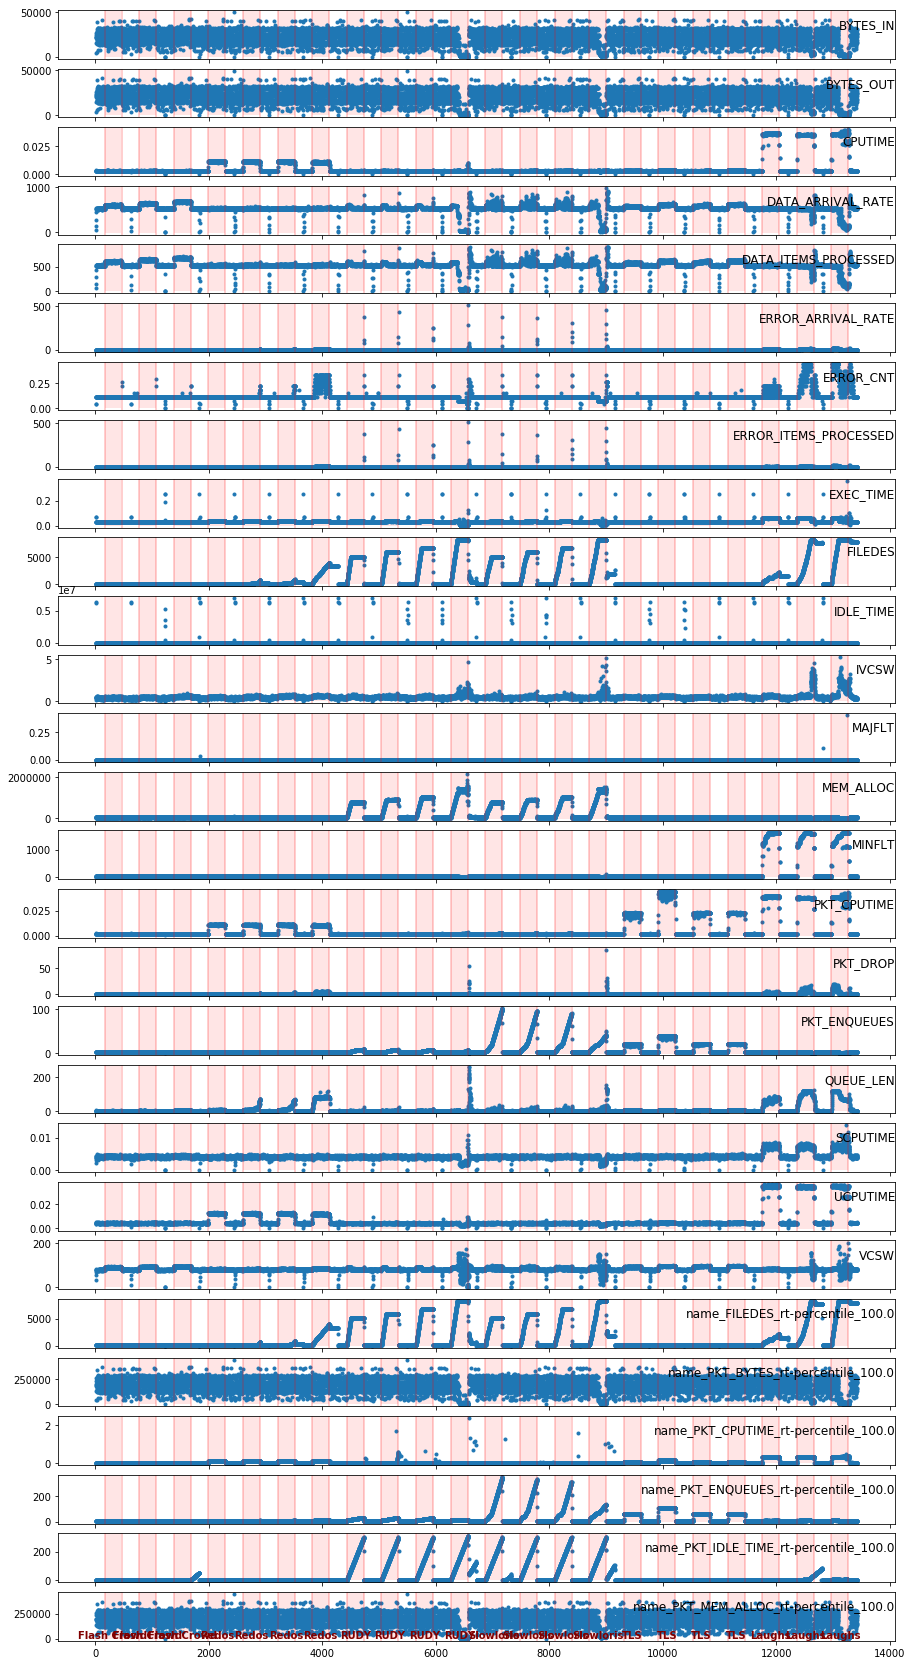

In [33]:
df, cols = get_built_df('avg_all', ['name'], [100], clear_cache=False)
plot_df(df, cols)